In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\aysen\OneDrive\Masaüstü\data mining proje factorio\analysis_ready_factorio.csv"  # per_min olan dosyan

df = pd.read_csv(CSV_PATH)
df = df.sort_values("tick").reset_index(drop=True)

df["tick"] = pd.to_numeric(df["tick"], errors="coerce").astype("int64")
df["time_s"] = pd.to_numeric(df["time_s"], errors="coerce") if "time_s" in df.columns else df["tick"]/60
df["logsim_power"] = pd.to_numeric(df["logsim_power"], errors="coerce")

print("rows:", len(df), "cols:", df.shape[1])
print("tick:", df["tick"].min(), "->", df["tick"].max())

rows: 365 cols: 517
tick: 2268000 -> 3578400


In [2]:
# production rates
prod_rate_cols = [c for c in df.columns if c.startswith("production__") and c.endswith("_per_min")]

print("production__*_per_min cols:", len(prod_rate_cols))
print("sample:", prod_rate_cols[:15])

if len(prod_rate_cols) == 0:
    raise ValueError("No production__*_per_min columns found in this CSV. Wrong file or naming mismatch.")

df[prod_rate_cols] = df[prod_rate_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

df["throughput_total_per_min"] = df[prod_rate_cols].sum(axis=1)

print("throughput>0:", (df["throughput_total_per_min"] > 0).sum())
print("power>0:", (df["logsim_power"].fillna(0) > 0).sum())


production__*_per_min cols: 24
sample: ['production__transport-belt_per_min', 'production__inserter_per_min', 'production__pipe_per_min', 'production__stone-furnace_per_min', 'production__wood_per_min', 'production__coal_per_min', 'production__stone_per_min', 'production__iron-ore_per_min', 'production__copper-ore_per_min', 'production__iron-plate_per_min', 'production__copper-plate_per_min', 'production__iron-gear-wheel_per_min', 'production__copper-cable_per_min', 'production__electronic-circuit_per_min', 'production__automation-science-pack_per_min']
throughput>0: 365
power>0: 365


In [3]:
dfA = df[(df["logsim_power"].fillna(0) > 0) & (df["throughput_total_per_min"] > 0)].copy()
dfA = dfA.sort_values("tick").reset_index(drop=True)

print("Active rows:", len(dfA))
print("tick range:", dfA["tick"].min(), "->", dfA["tick"].max())
dfA[["tick","time_s","logsim_power","throughput_total_per_min"]].head(5)

Active rows: 365
tick range: 2268000 -> 3578400


,tick,time_s,logsim_power,throughput_total_per_min
0,2268000,37800,90000.0,2755.0
1,2271600,37860,90000.0,2415.0
2,2275200,37920,90000.0,2094.0
3,2278800,37980,86776.0,2482.0
4,2282400,38040,84867.0,2425.0


In [8]:
import numpy as np
import pandas as pd

def zscore(s):
    s = pd.to_numeric(s, errors="coerce")
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

dfA = dfA.sort_values("tick").reset_index(drop=True)

w = 15
minp = 5

dfA["tp_ma"] = dfA["throughput_total_per_min"].rolling(w, min_periods=minp).mean()
dfA["p_ma"]  = dfA["logsim_power"].rolling(w, min_periods=minp).mean()

eps = 1e-9

dfA["tp_logratio"] = np.log((dfA["throughput_total_per_min"] + eps) / (dfA["tp_ma"] + eps))
dfA["p_logratio"]  = np.log((dfA["logsim_power"] + eps) / (dfA["p_ma"] + eps))

dfA["max_item_rate"] = dfA[prod_rate_cols].max(axis=1)
dfA["share_max"] = dfA["max_item_rate"] / dfA["throughput_total_per_min"].replace(0, np.nan)
dfA["imbalance_std"] = dfA[prod_rate_cols].std(axis=1)

dfA["dominant_item"] = dfA[prod_rate_cols].idxmax(axis=1)
dfA["dominant_rate"] = dfA["max_item_rate"]

dfA["tp_z"] = zscore(dfA["tp_logratio"])
dfA["p_z"]  = zscore(dfA["p_logratio"])
dfA["share_z"] = zscore(dfA["share_max"])
dfA["imb_z"]   = zscore(dfA["imbalance_std"])

dfA["bottleneck_score"] = (-dfA["tp_z"]) + (0.7*dfA["p_z"]) + (0.2*dfA["share_z"]) + (0.2*dfA["imb_z"])

print("bottleneck_score non-null:", dfA["bottleneck_score"].notna().sum(), "out of", len(dfA))
dfA[["tp_logratio","p_logratio","share_max","imbalance_std","bottleneck_score"]].describe()


bottleneck_score non-null: 361 out of 365


,tp_logratio,p_logratio,share_max,imbalance_std,bottleneck_score
count,361.000000,361.000000,365.000000,365.000000,361.000000
mean,-0.183052,-0.023922,0.414263,113.914449,-0.002930
std,0.636965,0.247751,0.179713,68.695007,0.957677
min,-1.888446,-0.801495,0.191589,11.430952,-2.673566
25%,-0.470004,-0.160029,0.306798,43.890840,-0.512036
50%,-0.065495,-0.030591,0.347222,119.970739,-0.169942
75%,0.128537,0.068156,0.455910,149.076572,0.245961
max,2.011037,0.743545,1.000000,272.410067,3.716557


In [9]:
thr = dfA.loc[dfA["bottleneck_score"].notna(), "bottleneck_score"].quantile(0.95)
dfA["is_bn"] = (dfA["bottleneck_score"] >= thr).fillna(False).astype(bool)

bn = dfA[dfA["is_bn"]].copy()

print("threshold q95:", thr)
print("bn rows:", len(bn))

bn[["tick","time_s","logsim_power","throughput_total_per_min","tp_logratio","p_logratio",
    "share_max","imbalance_std","dominant_item","dominant_rate","bottleneck_score"]].sort_values(
    "bottleneck_score", ascending=False
).head(25)


threshold q95: 2.3071657588892265
bn rows: 19


,tick,time_s,logsim_power,throughput_total_per_min,tp_logratio,p_logratio,share_max,imbalance_std,dominant_item,dominant_rate,bottleneck_score
240,3132000,52200,107380.0,93.0,-1.443244,0.456540,1.000000,18.983546,production__coal_per_min,93.0,3.716557
234,3110400,51840,95525.0,270.0,-1.162456,0.695112,0.518519,31.939140,production__iron-plate_per_min,140.0,3.451326
235,3114000,51900,102983.0,275.0,-1.014352,0.716947,0.472727,31.946939,production__iron-plate_per_min,130.0,3.229259
236,3117600,51960,113326.0,289.0,-0.820141,0.743545,0.477509,33.521543,production__iron-plate_per_min,138.0,3.009108
260,3204000,53400,82423.0,65.0,-1.853088,-0.034358,1.000000,13.268069,production__coal_per_min,65.0,2.955304
261,3207600,53460,83849.0,67.0,-1.762991,-0.007805,1.000000,13.676318,production__coal_per_min,67.0,2.889980
259,3200400,53340,77944.0,66.0,-1.888446,-0.092009,1.000000,13.472194,production__coal_per_min,66.0,2.848374
262,3211200,53520,83778.0,66.0,-1.686212,-0.006908,1.000000,13.472194,production__coal_per_min,66.0,2.771216
258,3196800,53280,76278.0,69.0,-1.868303,-0.117093,1.000000,14.084566,production__coal_per_min,69.0,2.747521
239,3128400,52140,110626.0,177.0,-0.965171,0.536690,0.525424,21.459390,production__coal_per_min,93.0,2.670081


In [12]:
import pandas as pd
import numpy as np

def extract_bn_episodes(
    df: pd.DataFrame,
    time_col: str = "time_s",          # or "tick" if you prefer
    flag_col: str = "is_bn",
    prod_cols: list[str] = None,
    score_col: str = "bottleneck_score",
    min_len: int = 2,                  # minimum episode duration in minutes
    merge_gap: int = 0                 # merge episodes separated by <= merge_gap non-bn minutes
) -> pd.DataFrame:

    d = df.copy()
    d = d.sort_values(time_col).reset_index(drop=True)

    if prod_cols is None:
        prod_cols = [c for c in d.columns if c.startswith("production__") and c.endswith("_per_min")]
    if not prod_cols:
        raise ValueError("No production__*_per_min columns found. Pass prod_cols explicitly.")

    d[flag_col] = d[flag_col].fillna(False).astype(bool)

    # run boundaries
    x = d[flag_col].to_numpy()
    start_of_run = np.r_[True, x[1:] != x[:-1]]
    run_id = start_of_run.cumsum()
    d["_run"] = run_id

    # raw bn runs
    runs = (
        d[d[flag_col]]
        .groupby("_run", as_index=False)
        .agg(
            start=(time_col, "min"),
            end=(time_col, "max"),
            minutes=(time_col, "size"),
        )
        .sort_values("start")
        .reset_index(drop=True)
    )

    # optional merge by small gaps
    if merge_gap > 0 and len(runs) > 0:
        merged = []
        cur = runs.loc[0].to_dict()
        for i in range(1, len(runs)):
            nxt = runs.loc[i].to_dict()
            gap = int(nxt["start"] - cur["end"]) - 1  # time_col is in seconds or ticks? see note below
            if gap <= merge_gap:
                cur["end"] = max(cur["end"], nxt["end"])
                cur["minutes"] = None  # recompute later
            else:
                merged.append(cur)
                cur = nxt
        merged.append(cur)
        runs = pd.DataFrame(merged)

    # convert time units into minutes properly
    # time_s seems to be in seconds. Your data is per minute so step is 60.
    step = int(pd.Series(d[time_col].diff().dropna()).mode().iloc[0]) if len(d) > 1 else 60
    if step <= 0:
        step = 60

    # finalize episodes with dominant item computed over the whole episode
    episodes = []
    for ep_id, r in enumerate(runs.itertuples(index=False), start=1):
        mask = (d[time_col] >= r.start) & (d[time_col] <= r.end) & d[flag_col]
        chunk = d.loc[mask]

        # duration in minutes based on step
        duration_min = int((chunk[time_col].max() - chunk[time_col].min()) / step) + 1 if len(chunk) else 0
        if duration_min < min_len:
            continue

        # dominant item for the episode based on summed production during the episode
        sums = chunk[prod_cols].sum(axis=0)
        total = float(sums.sum())
        dom_item = str(sums.idxmax()) if total > 0 else None
        dom_share = float(sums.max() / total) if total > 0 else np.nan

        peak = float(chunk[score_col].max()) if score_col in chunk.columns and len(chunk) else np.nan
        mean = float(chunk[score_col].mean()) if score_col in chunk.columns and len(chunk) else np.nan

        episodes.append({
            "episode_id": ep_id,
            "start": int(chunk[time_col].min()),
            "end": int(chunk[time_col].max()),
            "duration_min": duration_min,
            "dominant_item": dom_item,
            "dominant_share": dom_share,
            "peak_score": peak,
            "mean_score": mean,
            "bn_minutes": int(len(chunk))
        })

    ep = pd.DataFrame(episodes).sort_values(["peak_score","duration_min"], ascending=[False, False]).reset_index(drop=True)
    return ep

episodes = extract_bn_episodes(
    dfA,
    time_col="time_s",
    flag_col="is_bn",
    prod_cols=prod_rate_cols,
    score_col="bottleneck_score",
    min_len=2,
    merge_gap=0
)

episodes

,episode_id,start,end,duration_min,dominant_item,dominant_share,peak_score,mean_score,bn_minutes
0,1,51840,52200,7,production__iron-plate_per_min,0.419976,3.716557,2.992544,7
1,2,53280,53640,7,production__coal_per_min,1.000000,2.955304,2.753220,7
2,3,58800,58980,4,production__coal_per_min,0.738602,2.565806,2.488416,4


In [14]:
import numpy as np
import pandas as pd

def simulate_capacity_increase(
    df: pd.DataFrame,
    episodes: pd.DataFrame,
    pct_increase: float = 0.20,
    time_col: str = "time_s",
    throughput_col: str = "throughput_total_per_min",
    prod_cols: list[str] = None,
):
    d = df.copy()
    d = d.sort_values(time_col).reset_index(drop=True)

    if prod_cols is None:
        prod_cols = [c for c in d.columns if c.startswith("production__") and c.endswith("_per_min")]
    if not prod_cols:
        raise ValueError("No production__*_per_min columns found.")

    # baseline
    d["throughput_base"] = d[throughput_col].astype(float)

    # capacity proxy for each minute: sum of per item production rates
    d["cap_sum_base"] = d[prod_cols].sum(axis=1).astype(float)

    # initialize scenario columns
    d["throughput_scn"] = d["throughput_base"].copy()
    d["cap_sum_scn"] = d["cap_sum_base"].copy()
    d["delta_tp"] = 0.0
    d["scn_tag"] = ""

    episode_impacts = []

    for r in episodes.itertuples(index=False):
        start, end = int(r.start), int(r.end)
        dom = r.dominant_item
        if dom not in d.columns:
            continue

        mask = (d[time_col] >= start) & (d[time_col] <= end)

        # increase dominant item capacity only inside the episode
        dom_base = d.loc[mask, dom].astype(float)
        dom_new = dom_base * (1.0 + pct_increase)

        # recompute cap_sum under scenario (only dominant changes)
        cap_base = d.loc[mask, "cap_sum_base"]
        cap_new = cap_base + (dom_new - dom_base)

        # added capacity available from dominant during episode
        added_dom = (dom_new - dom_base)

        # conservative throughput lift: can only rise up to the new total capacity
        tp_base = d.loc[mask, "throughput_base"]
        tp_candidate = tp_base + added_dom

        tp_new = np.minimum(tp_candidate, cap_new)

        # write back
        d.loc[mask, "cap_sum_scn"] = cap_new
        d.loc[mask, "throughput_scn"] = tp_new
        d.loc[mask, "delta_tp"] = tp_new - tp_base
        d.loc[mask, "scn_tag"] = f"ep{int(r.episode_id)}_{dom}_plus{int(pct_increase*100)}"

        episode_impacts.append({
            "episode_id": int(r.episode_id),
            "start": start,
            "end": end,
            "dominant_item": dom,
            "duration_min": int(r.duration_min),
            "tp_base_sum": float(tp_base.sum()),
            "tp_scn_sum": float(tp_new.sum()),
            "tp_delta_sum": float((tp_new - tp_base).sum()),
            "tp_delta_per_min": float((tp_new - tp_base).mean()),
            "pct_gain_over_episode": float(((tp_new.sum() - tp_base.sum()) / (tp_base.sum() + 1e-9)) * 100.0),
        })

    impact = pd.DataFrame(episode_impacts).sort_values("tp_delta_sum", ascending=False).reset_index(drop=True)
    total_base = float(d["throughput_base"].sum())
    total_scn  = float(d["throughput_scn"].sum())
    total_delta = total_scn - total_base

    totals = {
        "total_tp_base_sum": total_base,
        "total_tp_scn_sum": total_scn,
        "total_tp_delta_sum": total_delta,
        "total_pct_gain": (total_delta / (total_base + 1e-9)) * 100.0,
    }

    return d, impact, totals

df_sim, impact_by_episode, totals = simulate_capacity_increase(
    dfA, episodes,
    pct_increase=0.20,
    time_col="time_s",
    throughput_col="throughput_total_per_min",
    prod_cols=prod_rate_cols
)

impact_by_episode, totals


(   episode_id  start    end                   dominant_item  duration_min  \
 0           1  51840  52200  production__iron-plate_per_min             7   
 1           2  53280  53640        production__coal_per_min             7   
 2           3  58800  58980        production__coal_per_min             4   
 
    tp_base_sum  tp_scn_sum  tp_delta_sum  tp_delta_per_min  \
 0       1662.0      1801.6         139.6         19.942857   
 1        470.0       564.0          94.0         13.428571   
 2        329.0       377.6          48.6         12.150000   
 
    pct_gain_over_episode  
 0               8.399519  
 1              20.000000  
 2              14.772036  ,
 {'total_tp_base_sum': 455503.0,
  'total_tp_scn_sum': 455785.2,
  'total_tp_delta_sum': 282.20000000001164,
  'total_pct_gain': 0.061953488780537344})

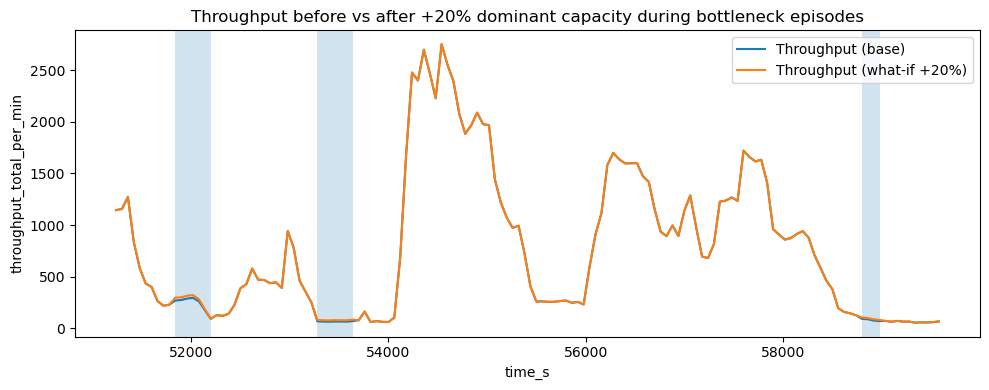

In [15]:
import matplotlib.pyplot as plt

# plot window around the bottleneck region for readability
tmin = episodes["start"].min() - 600   # 10 min before
tmax = episodes["end"].max() + 600     # 10 min after
m = (df_sim["time_s"] >= tmin) & (df_sim["time_s"] <= tmax)

x = df_sim.loc[m, "time_s"]
y0 = df_sim.loc[m, "throughput_base"]
y1 = df_sim.loc[m, "throughput_scn"]

plt.figure(figsize=(10,4))
plt.plot(x, y0, label="Throughput (base)")
plt.plot(x, y1, label="Throughput (what-if +20%)")

# shade episode intervals
for r in episodes.itertuples(index=False):
    plt.axvspan(r.start, r.end, alpha=0.2)

plt.title("Throughput before vs after +20% dominant capacity during bottleneck episodes")
plt.xlabel("time_s")
plt.ylabel("throughput_total_per_min")
plt.legend()
plt.tight_layout()
plt.show()


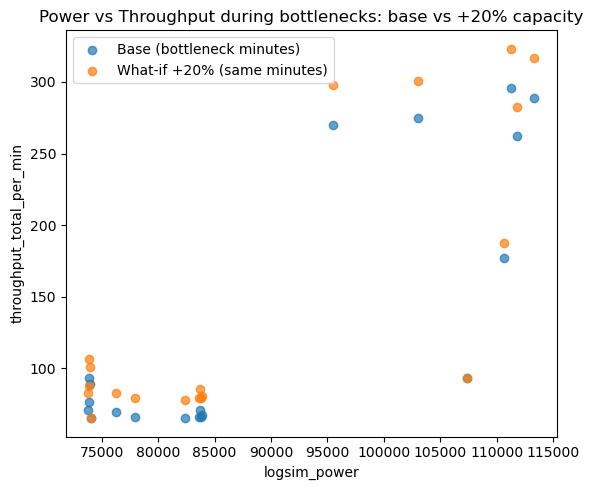

In [16]:
import matplotlib.pyplot as plt

# Focus only on bottleneck minutes
m = df_sim["is_bn"].astype(bool)

x_power = df_sim.loc[m, "logsim_power"]
y_base  = df_sim.loc[m, "throughput_base"]
y_scn   = df_sim.loc[m, "throughput_scn"]

plt.figure(figsize=(6,5))
plt.scatter(x_power, y_base, alpha=0.7, label="Base (bottleneck minutes)")
plt.scatter(x_power, y_scn,  alpha=0.7, label="What-if +20% (same minutes)")

plt.xlabel("logsim_power")
plt.ylabel("throughput_total_per_min")
plt.title("Power vs Throughput during bottlenecks: base vs +20% capacity")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# First, check if the column name might be different in the episodes DataFrame
# For example, it might be named differently like 'duration' instead of 'duration_min'

# Option 1: If the column exists with a different name, rename it before merging
# For example, if it's called 'duration' instead:
episodes_fixed = episodes.rename(columns={"duration": "duration_min"})

impact_ranked = impact_by_episode.merge(
    episodes_fixed[["episode_id", "peak_score", "duration_min"]],
    on="episode_id",
    how="left"
)

# Option 2: If the column doesn't exist at all, you might need to add it or remove it from calculations
# Here's how to proceed without the column:
impact_ranked = impact_by_episode.merge(
    episodes[["episode_id", "peak_score"]],  # Removed 'duration_min' from the list
    on="episode_id",
    how="left"
)

# Modify the priority score calculation to not use duration_min
impact_ranked["priority_score"] = (
    impact_ranked["tp_delta_sum"]
    * impact_ranked["peak_score"]
    # Removed duration_min from calculation
)

impact_ranked = impact_ranked.sort_values(
    "priority_score", ascending=False
).reset_index(drop=True)

impact_ranked

,episode_id,start,end,dominant_item,duration_min,tp_base_sum,tp_scn_sum,tp_delta_sum,tp_delta_per_min,pct_gain_over_episode,peak_score,priority_score
0,1,51840,52200,production__iron-plate_per_min,7,1662.0,1801.6,139.6,19.942857,8.399519,3.716557,518.831299
1,2,53280,53640,production__coal_per_min,7,470.0,564.0,94.0,13.428571,20.000000,2.955304,277.798532
2,3,58800,58980,production__coal_per_min,4,329.0,377.6,48.6,12.150000,14.772036,2.565806,124.698175


In [20]:
levels = [0.10, 0.20, 0.30]
rows = []

for lvl in levels:
    _, impact_tmp, totals_tmp = simulate_capacity_increase(
        dfA, episodes,
        pct_increase=lvl,
        time_col="time_s",
        throughput_col="throughput_total_per_min",
        prod_cols=prod_rate_cols
    )
    rows.append({
        "capacity_increase": int(lvl * 100),
        "total_tp_delta": totals_tmp["total_tp_delta_sum"],
        "total_pct_gain": totals_tmp["total_pct_gain"]
    })

sensitivity = pd.DataFrame(rows)
sensitivity


,capacity_increase,total_tp_delta,total_pct_gain
0,10,141.1,0.030977
1,20,282.2,0.061953
2,30,423.3,0.092930


In [10]:
bn_counts = bn["dominant_item"].value_counts()
all_counts = dfA["dominant_item"].value_counts()

summary = pd.concat([bn_counts, all_counts], axis=1)
summary.columns = ["bn_count", "all_count"]
summary = summary.fillna(0)

summary["bn_share"] = summary["bn_count"] / (summary["bn_count"].sum() + 1e-9)
summary["all_share"] = summary["all_count"] / (summary["all_count"].sum() + 1e-9)
summary["lift"] = (summary["bn_share"] + 1e-9) / (summary["all_share"] + 1e-9)

summary.sort_values("lift", ascending=False).head(25)


,bn_count,all_count,bn_share,all_share,lift
dominant_item,,,,,
production__coal_per_min,14.0,39,0.736842,0.106849,6.896086e+00
production__iron-plate_per_min,5.0,173,0.263158,0.473973,5.552175e-01
production__steel-plate_per_min,0.0,1,0.000000,0.002740,3.649999e-07
production__copper-cable_per_min,0.0,1,0.000000,0.002740,3.649999e-07
production__stone_per_min,0.0,1,0.000000,0.002740,3.649999e-07
production__iron-gear-wheel_per_min,0.0,2,0.000000,0.005479,1.825000e-07
production__iron-ore_per_min,0.0,148,0.000000,0.405479,2.466216e-09


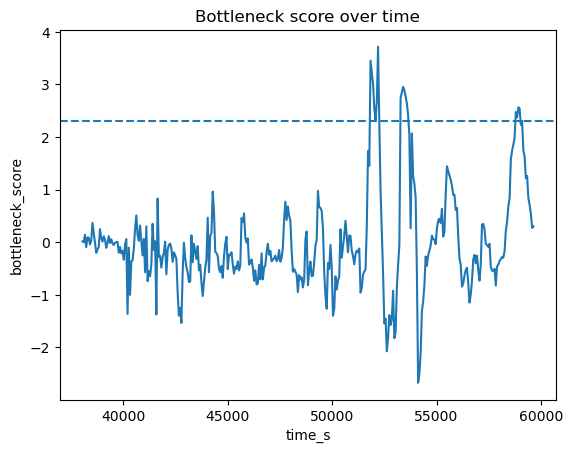

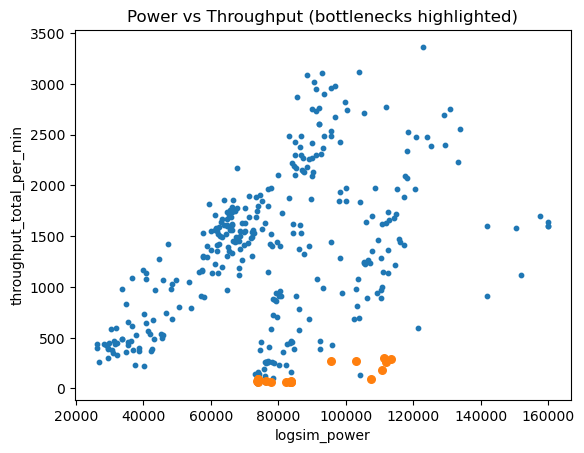

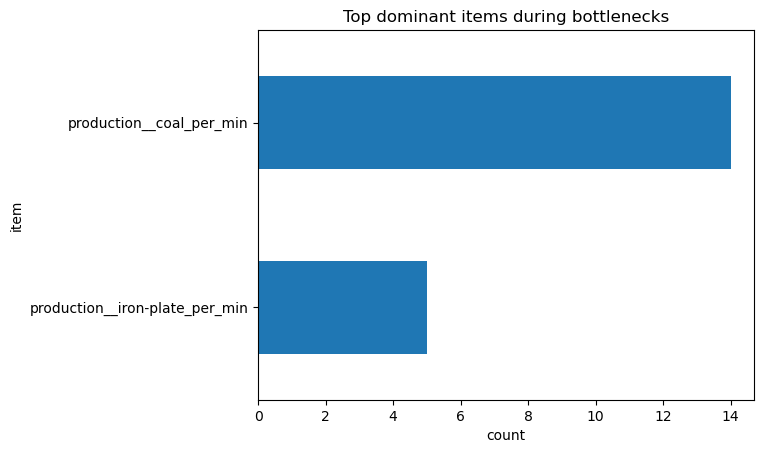

In [11]:
plt.figure()
plt.plot(dfA["time_s"], dfA["bottleneck_score"])
plt.axhline(thr, linestyle="--")
plt.title("Bottleneck score over time")
plt.xlabel("time_s")
plt.ylabel("bottleneck_score")
plt.show()

plt.figure()
mask = dfA["is_bn"]
plt.scatter(dfA.loc[~mask, "logsim_power"], dfA.loc[~mask, "throughput_total_per_min"], s=10)
plt.scatter(dfA.loc[mask, "logsim_power"], dfA.loc[mask, "throughput_total_per_min"], s=30)
plt.title("Power vs Throughput (bottlenecks highlighted)")
plt.xlabel("logsim_power")
plt.ylabel("throughput_total_per_min")
plt.show()

topk = bn["dominant_item"].value_counts().head(10)
plt.figure()
topk.sort_values().plot(kind="barh")
plt.title("Top dominant items during bottlenecks")
plt.xlabel("count")
plt.ylabel("item")
plt.show()
